# Check HMF of TNG to understand why SMFs are offset 

everything in h units

In [90]:
import hmf
from hmf import cosmo, MassFunction

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

from astropy.cosmology import Planck15, FlatLambdaCDM #TNG cosmology

import h5py

import pickle

In [12]:
def open_pkl(file_name):
    pkl = open(file_name,'rb')
    array = pickle.load(pkl)
    pkl.close()  
    return array

def compute_smf(log_masses, volume, n_bins, min_mass=None, max_mass=None):
    """
    Parameters
    ----------
    log_masses: ndarray
        Array of stellar mass values in log10 values

    volume : float
        volume of data in comoving Mpc^3

    n_bins : number of bins

    min_mass : min mass

    max_mass : max mass

    Returns
    -------
    m_centers : ndarray
        mass bin centers (x axis of SMF) in units of log10 M*

    log_phi : ndarray in units of dn / dlogM* in units of Mpc^-3 dex^-1

    log_err : ndarray
        log of Poisson error
    """
    if not min_mass:
        min_mass = min(log_masses)
    if not max_mass:
        max_mass = max(log_masses)
        
    Phi,edg = np.histogram(log_masses,bins=n_bins, range=[min_mass, max_mass]) #Unnormalized histogram and bin edges
    # Poisson error
    err = np.sqrt(Phi)
    
    #Bin size
    dM    = edg[1] - edg[0]                 
    m_centers   = edg[0:-1] + dM/2.           
    
    #Normalize to volume and bin size
    Phi   = Phi / float(volume) / dM        
    log_phi= np.log10(Phi) 

    # Also normalize the error
    err = err / float(volume) / dM 
    
    return m_centers, Phi, err


def bootstrap_smf(log_masses, volume, n_bins, min_mass, max_mass,
                  n_boots=1000, sm_err=None, resample_err=False):
    """
    Parameters
    ----------
    log_masses: ndarray
        Array of stellar mass values in log10 values

    volume : float
        volume of data in comoving Mpc^3

    n_bins : number of bins

    min_mass : min mass

    max_mass : max mass

    sm_err: ndarray, optional
        Array of stellar mass errors


    Returns
    -------
    m_centers : ndarray
        mass bin centers (x axis of SMF) in units of log10 M*

    log_phi : ndarray in units of dn / dlogM* in units of Mpc^-3 dex^-1

    log_err : ndarray
        log of Poisson error
        
    log_boot_err : ndarray
        log of Poisson error


    """

    m_centers, phi, err_poisson = compute_smf(log_masses, volume, n_bins, min_mass, max_mass)

    if resample_err:
        msg = "Need to provide the error of stellar mass!"
        assert sm_err is not None, msg
        sm_boots = np.asarray(map(lambda mass, err: np.random.normal(mass, err, n_boots),
                log_masses, sm_err))
    else:
        mass_boot_samples = bootstrap_resample(log_masses, n_boots=n_boots)

    phi_boots = np.vstack(compute_smf(mass_boot_samples[:, ii], volume, n_bins, sm_min, sm_max)[1] 
                              for ii in range(n_boots))
    
    #bootstrap error
    err_bootstrap=np.nanstd(phi_boots, axis=0)
    log_err_bootstrap=np.nanstd(np.log10(phi_boots[phi_boots != 0.0]), axis=0)
    
    
    
    return m_centers, phi, err_poisson, err_bootstrap, log_err_bootstrap, phi_boots

In [71]:
tng_cosmology = Planck15
HSC_cosmology = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.05, Tcmb0=2.725)

## Setup HMF Tinker model 

In [4]:
MassFunction.parameter_info()

Mmax : float
    Maximum mass at which to perform analysis [units :math:`\log_{10}M_\odot h^{-1}`].

growth_params : dict
    Relevant parameters of the :attr:`growth_model`.

Mmin : float
    Minimum mass at which to perform analysis [units :math:`\log_{10}M_\odot h^{-1}`].

growth_model : str or `hmf.growth_factor.GrowthFactor` subclass
    The model to use to calculate the growth function/growth rate.

transfer_model : str or :class:`hmf.transfer_models.TransferComponent` subclass, optional
    Defines which transfer function model to use.
    Built-in available models are found in the :mod:`hmf.transfer_models` module.
    Default is CAMB if installed, otherwise EH.

cosmo_params : dict
    Parameters for the cosmology that deviate from the base cosmology passed.
    This is useful for repeated updates of a single parameter (leaving others
    the same). Default is the empty dict. The parameters passed must match
    the allowed parameters of `cosmo_model`. For the basic class this

In [47]:
hmf = MassFunction(z=0.4, cosmo_model=Planck15, delta_h=200, delta_wrt='crit', Mmax=14.5, Mmin=10.5)
mass_func = hmf.dndlog10m #h^3/Mpc^3/dex
masses = hmf.m #Msun/h
hmf.parameter_values

{'Mmax': 14.5,
 'Mmin': 10.5,
 'cosmo_model': FlatLambdaCDM(name="Planck15", H0=67.7 km / (Mpc s), Om0=0.307, Tcmb0=2.725 K, Neff=3.05, m_nu=[0.   0.   0.06] eV, Ob0=0.0486),
 'cosmo_params': {},
 'delta_c': 1.686,
 'delta_h': 200.0,
 'delta_wrt': 'crit',
 'dlnk': 0.05,
 'dlog10m': 0.01,
 'filter_model': hmf.filters.TopHat,
 'filter_params': {},
 'growth_model': hmf.growth_factor.GrowthFactor,
 'growth_params': {},
 'hmf_model': hmf.fitting_functions.Tinker08,
 'hmf_params': {},
 'lnk_max': 9.903487552536127,
 'lnk_min': -18.420680743952367,
 'n': 0.9667,
 'sigma_8': 0.8159,
 'takahashi': True,
 'transfer_model': hmf.transfer_models.CAMB,
 'transfer_params': {},
 'z': 0.4}

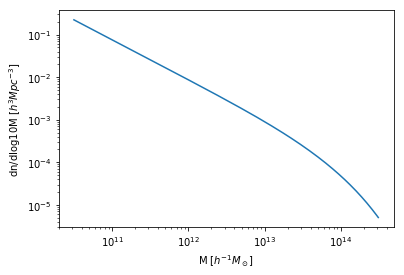

In [48]:
plt.loglog(masses,mass_func)
plt.ylabel(r'dn/dlog10M $[h^3 Mpc^{-3}]$')
plt.xlabel(r'M $[h^{-1}M_\odot]$')

plt.show()

## add tng 

In [15]:
tng_masses_file = '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/TNG/TNG_masses_highres.pkl'
tng_masses = open_pkl(tng_masses_file)

volume_tng=110.7**3 #Mpc^3
volume_tng_h = 75**3 #h^3Mpc^3
z = 0.4
h_tng = 0.6774

In [27]:
# in Msun/h units
sample_tng_Mtophat = np.log10((10**tng_masses['m_tophat200'])*h_tng)
mtophat_tng, smftophat_tng, errtophat_tng = compute_smf(sample_tng_Mtophat, volume_tng_h ,n_bins=10)

In [28]:
files_directory = '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/TNG/group_catalogs/'
M200c_file = 'fof_subhalo_tab_072.Group.Group_M_Crit200.hdf5'
MTopHat200_file = 'fof_subhalo_tab_072.Group.Group_M_TopHat200.hdf5'
# Mmean200_file = 'fof_subhalo_tab_072.Group.Group_M_Mean200.hdf5'

f = h5py.File(files_directory+M200c_file, 'r')
M200c = np.array(f['Group'][u'Group_M_Crit200'])* 1e10 #/ h_tng

f = h5py.File(files_directory+MTopHat200_file, 'r')
MTopHat200 = np.array(f['Group'][u'Group_M_TopHat200'])* 1e10 #/ h_tng
f.close()

# f = h5py.File(files_directory+Mmean200_file, 'r')
# M200m = np.array(f['Group'][u'Group_M_Mean200'])* 1e10 / h_tng
# f.close()

In [29]:
mtophat_tng_full, smftophat_tng_full, errtophat_tng_full = compute_smf(np.log10(MTopHat200),
                                                                       volume_tng_h,n_bins=30,
                                                                      min_mass=10)
mcrit_tng_full, smfcrit_tng_full, errcrit_tng_full = compute_smf(np.log10(M200c),
                                                                       volume_tng_h,n_bins=30,
                                                                      min_mass=10)

# mmean_tng_full, smfmean_tng_full, errmean_tng_full = compute_smf(np.log10(M200m),
#                                                                        volume_tng,n_bins=30,
#                                                                       min_mass=10)

/Users/fardila/anaconda/envs/hsc_hydro4/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/Users/fardila/anaconda/envs/hsc_hydro4/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log10


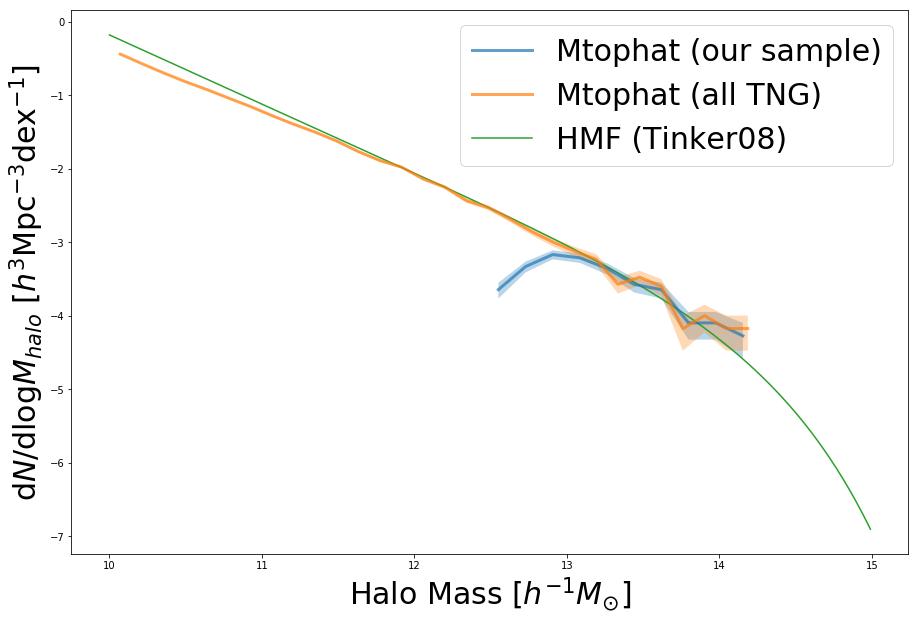

In [38]:
plt.figure(figsize=[15,10])

plt.plot(mtophat_tng,np.log10(smftophat_tng), linestyle='-', linewidth=3.0, zorder=10, alpha=0.7,
         label='Mtophat (our sample)')
plt.fill_between(mtophat_tng, np.log10(smftophat_tng-errtophat_tng), np.log10(smftophat_tng+errtophat_tng),
                 alpha=0.3, rasterized=True)

plt.plot(mtophat_tng_full,np.log10(smftophat_tng_full), linestyle='-', linewidth=3.0, zorder=10, alpha=0.7,
         label='Mtophat (all TNG)')
plt.fill_between(mtophat_tng_full,
                 np.log10(smftophat_tng_full-errtophat_tng_full), np.log10(smftophat_tng_full+errtophat_tng_full),
                 alpha=0.3, rasterized=True)

# plt.plot(mcrit_tng_full,np.log10(smfcrit_tng_full), linestyle='-', linewidth=3.0, zorder=10, alpha=0.7,
#          label='Mcrit200 (all TNG)')
# plt.fill_between(mcrit_tng_full,
#                  np.log10(smfcrit_tng_full-errcrit_tng_full), np.log10(smfcrit_tng_full+errcrit_tng_full),
#                  alpha=0.3, rasterized=True)



plt.plot(np.log10(masses),np.log10(mass_func), label='HMF (Tinker08)')
plt.ylabel(r'$\mathrm{d}N/\mathrm{d}\log M_{halo}\ [{h^3\mathrm{Mpc}^{-3}}{\mathrm{dex}^{-1}}]$', 
                   size=30)
plt.xlabel('Halo Mass [$h^{-1}M_{\odot}$]', size=30)
plt.legend(fontsize=30)
plt.show()


In [18]:
files_directory = '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/TNG/group_catalogs/'
M200c_file = 'tng300_fof_subhalo_tab_072.Group.Group_M_Crit200.hdf5'

f = h5py.File(files_directory+M200c_file, 'r')
M200c = np.array(f['Group'][u'Group_M_Crit200'])* 1e10 / h_tng

In [19]:
volume_tng300=302.6**3 #Mpc^3
volume_tng300_h = 205**3 #h^3Mpc^3
mcrit_tng_full, smfcrit_tng_full, errcrit_tng_full = compute_smf(np.log10(M200c),
                                                                       volume_tng300_h,n_bins=20,
                                                                      min_mass=10)

/Users/fardila/anaconda/envs/hsc_hydro4/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


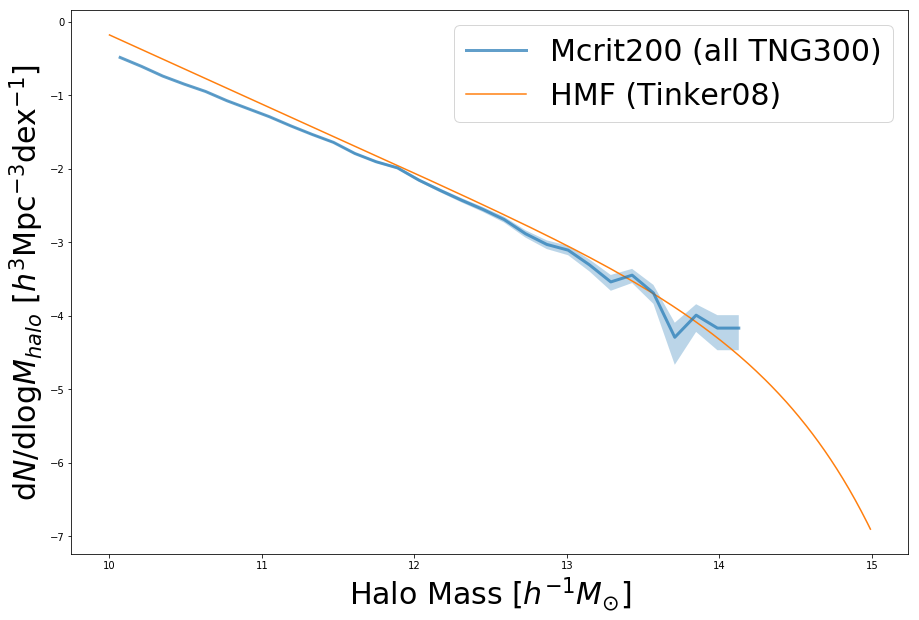

In [39]:
plt.figure(figsize=[15,10])


plt.plot(mcrit_tng_full,np.log10(smfcrit_tng_full),
         linestyle='-', linewidth=3.0, zorder=10, alpha=0.7, label='Mcrit200 (all TNG300)')
plt.fill_between(mcrit_tng_full,
                 np.log10(smfcrit_tng_full-errcrit_tng_full), np.log10(smfcrit_tng_full+errcrit_tng_full),
                 alpha=0.3, rasterized=True)



plt.plot(np.log10(masses),np.log10(mass_func), label='HMF (Tinker08)')
plt.ylabel(r'$\mathrm{d}N/\mathrm{d}\log M_{halo}\ [{h^3\mathrm{Mpc}^{-3}}{\mathrm{dex}^{-1}}]$', 
                   size=30)
plt.xlabel('Halo Mass [$h^{-1}M_{\odot}$]', size=30)
plt.legend(fontsize=30)
plt.show()


## MDPL2 errors from Enia

In [40]:
mdpl2_file = '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/other/jn_errors_felipe_hmf.npz'
mdpl2_array = np.load(mdpl2_file)
mdpl2_array.keys()

['mean', 'err', 'mcen']

In [41]:
h_mdpl2 = 0.6777

# mdpl2_mean = mdpl2_array['mean']*(h_mdpl2**3)
# mdpl2_err = mdpl2_array['err']*(h_mdpl2**3)
# mdpl2_M_bin = np.log10((10**mdpl2_array['mcen'])/h_mdpl2)


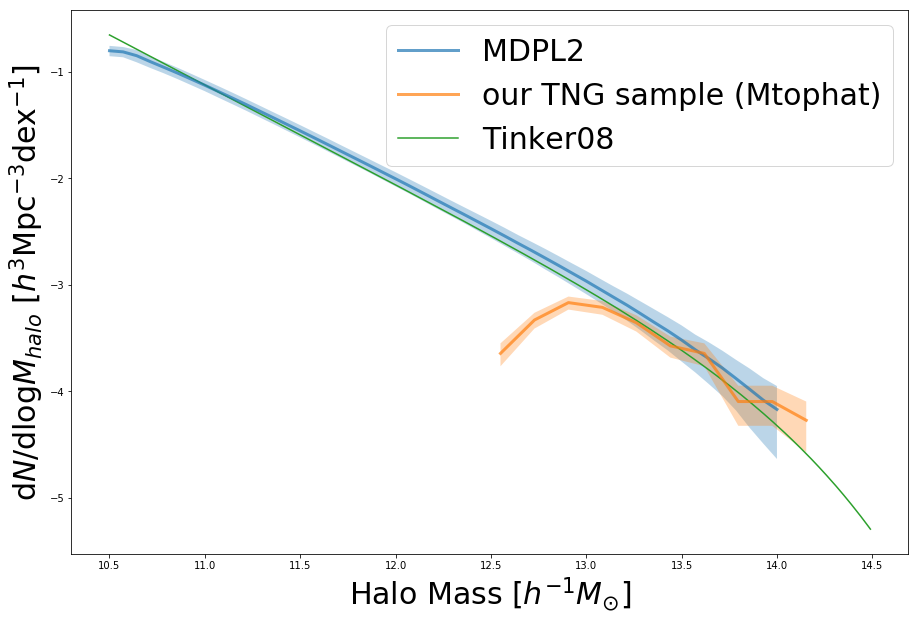

In [75]:
plt.figure(figsize=[15,10])

# plt.plot(mdpl2_M_bin,
#          np.log10(mdpl2_mean),
#          linestyle='-', linewidth=3.0, zorder=10, alpha=0.7, label='MDPL2')
# plt.fill_between(mdpl2_M_bin,
#                  np.log10(mdpl2_mean-mdpl2_err),
#                  np.log10(mdpl2_mean+mdpl2_err),
#                  alpha=0.3, rasterized=True)

plt.plot(mdpl2_array['mcen'],
         np.log10(mdpl2_array['mean']),
         linestyle='-', linewidth=3.0, zorder=10, alpha=0.7, label='MDPL2')
plt.fill_between(mdpl2_array['mcen'],
                 np.log10(mdpl2_array['mean']-mdpl2_array['err']),
                 np.log10(mdpl2_array['mean']+mdpl2_array['err']),
                 alpha=0.3, rasterized=True)



plt.plot(mtophat_tng,np.log10(smftophat_tng), linestyle='-', linewidth=3.0, zorder=10, alpha=0.7,
         label='our TNG sample (Mtophat)')
plt.fill_between(mtophat_tng, np.log10(smftophat_tng-errtophat_tng), np.log10(smftophat_tng+errtophat_tng),
                 alpha=0.3, rasterized=True)

# plt.plot(mtophat_tng_full,np.log10(smftophat_tng_full), linestyle='-', linewidth=3.0, zorder=10, alpha=0.7,
#          label='Mtophat (all TNG)')
# plt.fill_between(mtophat_tng_full,
#                  np.log10(smftophat_tng_full-errtophat_tng_full), np.log10(smftophat_tng_full+errtophat_tng_full),
#                  alpha=0.3, rasterized=True)


plt.plot(np.log10(masses),np.log10(mass_func), label='Tinker08')
plt.ylabel(r'$\mathrm{d}N/\mathrm{d}\log M_{halo}\ [{h^3\mathrm{Mpc}^{-3}}{\mathrm{dex}^{-1}}]$', 
                   size=30)
plt.xlabel('Halo Mass [$h^{-1}M_{\odot}$]', size=30)
plt.legend(fontsize=30)
plt.show()


/Users/fardila/anaconda/envs/hsc_hydro4/lib/python2.7/site-packages/ipykernel/__main__.py:25: RuntimeWarning: invalid value encountered in log10


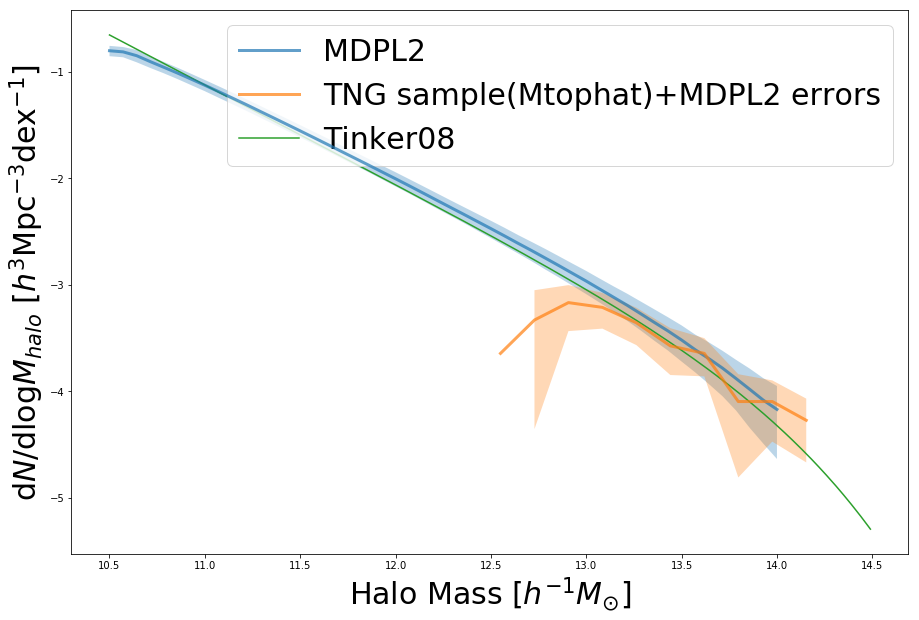

In [98]:
plt.figure(figsize=[15,10])

# plt.plot(mdpl2_M_bin,
#          np.log10(mdpl2_mean),
#          linestyle='-', linewidth=3.0, zorder=10, alpha=0.7, label='MDPL2')
# plt.fill_between(mdpl2_M_bin,
#                  np.log10(mdpl2_mean-mdpl2_err),
#                  np.log10(mdpl2_mean+mdpl2_err),
#                  alpha=0.3, rasterized=True)

plt.plot(mdpl2_array['mcen'],
         np.log10(mdpl2_array['mean']),
         linestyle='-', linewidth=3.0, zorder=10, alpha=0.7, label='MDPL2')
plt.fill_between(mdpl2_array['mcen'],
                 np.log10(mdpl2_array['mean']-mdpl2_array['err']),
                 np.log10(mdpl2_array['mean']+mdpl2_array['err']),
                 alpha=0.3, rasterized=True)


mdpl_errors_for_TNG = interp1d( mdpl2_array['mcen'], mdpl2_array['err'], fill_value='extrapolate')(mtophat_tng)

plt.plot(mtophat_tng,np.log10(smftophat_tng), linestyle='-', linewidth=3.0, zorder=10, alpha=0.7,
         label='TNG sample(Mtophat)+MDPL2 errors')
plt.fill_between(mtophat_tng,
                 np.log10(smftophat_tng-mdpl_errors_for_TNG),
                 np.log10(smftophat_tng+mdpl_errors_for_TNG),
                 alpha=0.3, rasterized=True)

# plt.plot(mtophat_tng_full,np.log10(smftophat_tng_full), linestyle='-', linewidth=3.0, zorder=10, alpha=0.7,
#          label='Mtophat (all TNG)')
# plt.fill_between(mtophat_tng_full,
#                  np.log10(smftophat_tng_full-errtophat_tng_full), np.log10(smftophat_tng_full+errtophat_tng_full),
#                  alpha=0.3, rasterized=True)


plt.plot(np.log10(masses),np.log10(mass_func), label='Tinker08')
plt.ylabel(r'$\mathrm{d}N/\mathrm{d}\log M_{halo}\ [{h^3\mathrm{Mpc}^{-3}}{\mathrm{dex}^{-1}}]$', 
                   size=30)
plt.xlabel('Halo Mass [$h^{-1}M_{\odot}$]', size=30)
plt.legend(loc='upper right', fontsize=30)
plt.show()


## compare cosmologies 

In [72]:
hmf_TNG_cosmo = MassFunction(z=0.4, cosmo_model=tng_cosmology, delta_h=200, delta_wrt='crit', Mmax=14.5, Mmin=10.5)
hmf_HSC_cosmo = MassFunction(z=0.4, cosmo_model=HSC_cosmology, delta_h=200, delta_wrt='crit', Mmax=14.5, Mmin=10.5)


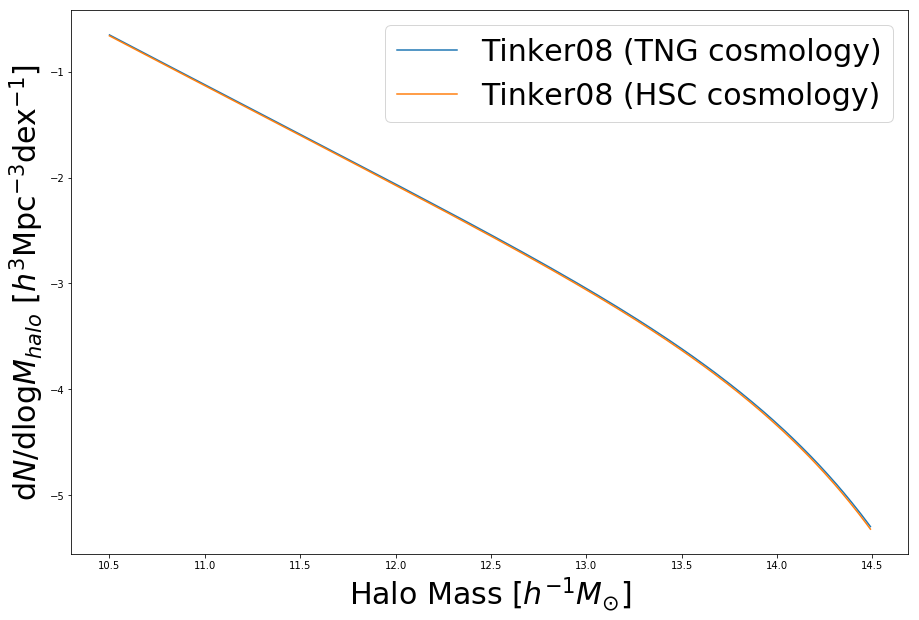

In [73]:
plt.figure(figsize=[15,10])



plt.plot(np.log10(hmf_TNG_cosmo.m),np.log10(hmf_TNG_cosmo.dndlog10m), label='Tinker08 (TNG cosmology)')
plt.plot(np.log10(hmf_HSC_cosmo.m),np.log10(hmf_HSC_cosmo.dndlog10m), label='Tinker08 (HSC cosmology)')

plt.ylabel(r'$\mathrm{d}N/\mathrm{d}\log M_{halo}\ [{h^3\mathrm{Mpc}^{-3}}{\mathrm{dex}^{-1}}]$', 
                   size=30)
plt.xlabel('Halo Mass [$h^{-1}M_{\odot}$]', size=30)
plt.legend(fontsize=30)
plt.show()



not much of a difference